In [ ]:
"""Implementation of sample attack."""
import os
import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms import ToTensor, ToPILImage, transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
from Normalize import Normalize
from loader import ImageNet
from torch.utils.data import DataLoader

In [ ]:
img_size = 299
adv_dir = r"dataset/images"
input_csv = r"dataset/images.csv"
X = ImageNet(adv_dir, input_csv, T.Compose([T.ToTensor(), T.Resize(img_size)]))
data_loader = DataLoader(X, batch_size=10)

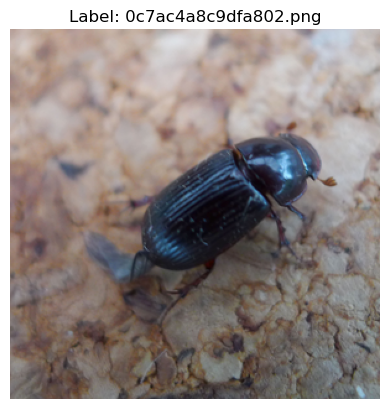

In [ ]:
import matplotlib.pyplot as plt
dataiter = iter(data_loader)
images, labels,_ = next(dataiter)


img = images[0]
 
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class RobustDenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(RobustDenoisingAutoencoder, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
        ) 
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2), 
        )  
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2)  
        ) 

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
        )  
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, output_padding=1), 
        ) 
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )  

        self.residual_conv = nn.Conv2d(3, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)      
        e2 = self.enc2(e1)    
        e3 = self.enc3(e2)     

        d3 = self.dec3(e3)     
        crop_size = 146
        start = (149 - crop_size) // 2  
        e2_cropped = e2[:, :, start:start + crop_size, start:start + crop_size]  
        d3 = torch.cat([d3, e2_cropped], dim=1)  
        d2 = self.dec2(d3)     
        d2 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False)

        d2 = torch.cat([d2, e1], dim=1) 
        decoded = self.dec1(d2)  

        residual = self.residual_conv(x)
        output = decoded + residual
        return torch.clamp(output, 0., 1.)

def add_random_noise(images, noise_factor=0.3):
    noise_type = torch.randint(0, 3, (1,)).item()
    if noise_type == 0: 
        noisy = images + noise_factor * torch.randn_like(images)
    elif noise_type == 1:  
        mask = torch.rand_like(images) < noise_factor
        noisy = images.clone()
        noisy[mask] = torch.randint(0, 2, noisy[mask].shape, device=images.device).float()
    else: 
        noisy = images + images * noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobustDenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, min_lr=1e-6)
num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0
    for data in data_loader:
        images, _, _ = data
        images = images.to(device)

        noisy_images = add_random_noise(images)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    scheduler.step(avg_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/30], Loss: 0.0646
Epoch [2/30], Loss: 0.0235
Epoch [3/30], Loss: 0.0141
Epoch [4/30], Loss: 0.0112
Epoch [5/30], Loss: 0.0101
Epoch [6/30], Loss: 0.0086
Epoch [7/30], Loss: 0.0084
Epoch [8/30], Loss: 0.0077
Epoch [9/30], Loss: 0.0074
Epoch [10/30], Loss: 0.0068
Epoch [11/30], Loss: 0.0074
Epoch [12/30], Loss: 0.0069
Epoch [13/30], Loss: 0.0064
Epoch [14/30], Loss: 0.0064
Epoch [15/30], Loss: 0.0063
Epoch [16/30], Loss: 0.0060
Epoch [17/30], Loss: 0.0059
Epoch [18/30], Loss: 0.0062
Epoch [19/30], Loss: 0.0061
Epoch [20/30], Loss: 0.0057
Epoch [21/30], Loss: 0.0059
Epoch [22/30], Loss: 0.0056
Epoch [23/30], Loss: 0.0056
Epoch [24/30], Loss: 0.0056
Epoch [25/30], Loss: 0.0054
Epoch [26/30], Loss: 0.0051
Epoch [27/30], Loss: 0.0053
Epoch [28/30], Loss: 0.0049
Epoch [29/30], Loss: 0.0049
Epoch [30/30], Loss: 0.0051


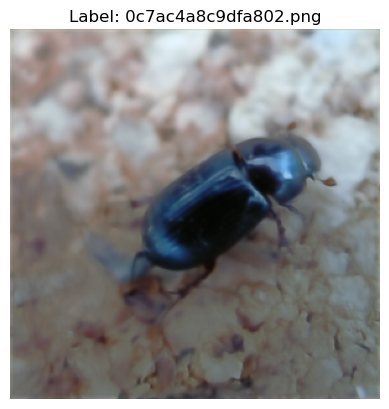

Image shape: torch.Size([3, 299, 299])
Label: 0c7ac4a8c9dfa802.png
Third field: 305


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
model.eval()
denoised_data = []

with torch.no_grad():
    for batch in data_loader:
        images, labels, third_field = batch

        images = images.to(device)

        denoised_images = model(images)

        for i in range(len(images)):
            denoised_data.append((
                denoised_images[i].cpu(), 
                labels[i],             
                third_field[i]            
            ))

class DenoisedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label, third = self.data[idx]
        return image, label, third


denoised_dataset = DenoisedDataset(denoised_data)
new_data_loader = DataLoader(denoised_dataset, batch_size=10, shuffle=False) 

dataiter = iter(new_data_loader)
images, labels, third_field = next(dataiter)

img = images[0].permute(1, 2, 0)  
plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

print(f"Image shape: {images[0].shape}")
print(f"Label: {labels[0]}")
print(f"Third field: {third_field[0]}")

In [ ]:
def verify(model, model_name, data_loader):
    img_size = 299
    sum = 0
    for images, _,gt_cpu in data_loader:  
        gt = gt_cpu.cuda()
        images = images.cuda()
        with torch.no_grad():
            sum += (model(images).argmax(1) == gt).detach().sum().cpu()

    print(model_name + '  acu = {:.2%}'.format(sum / 1000.0))

In [ ]:
import pretrainedmodels
model_test = torch.nn.Sequential(Normalize(np.array([0.5, 0.5, 0.5]),np.array([0.5, 0.5, 0.5])),
                                pretrainedmodels.inceptionv3(num_classes=1000, pretrained='imagenet').eval().cuda())

C:\Users\CSE IIT BHILAI\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CSE IIT BHILAI\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\CSE IIT BHILAI\anaconda3\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
verify(model_test,"j",data_loader)

j  acu = 95.10%


In [ ]:
img_size = 299
adv_dir = r"incv3_stm_outputs"
input_csv = r"dataset/images.csv"
X = ImageNet(adv_dir, input_csv, T.Compose([T.ToTensor(), T.Resize(img_size)]))
data_loader = DataLoader(X, batch_size=10)

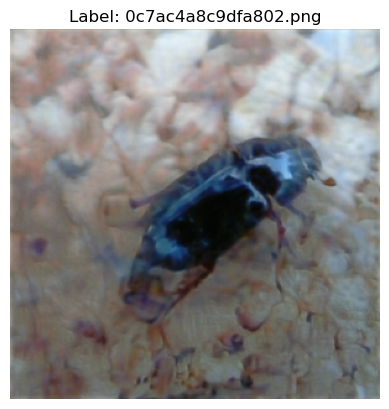

Image shape: torch.Size([3, 299, 299])
Label: 0c7ac4a8c9dfa802.png
Third field: 305


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

model.eval()
denoised_data = []

with torch.no_grad():
    for batch in data_loader:
        images, labels, third_field = batch  
        images = images.to(device)
        denoised_images = model(images)  
        for i in range(len(images)):
            denoised_data.append((
                denoised_images[i].cpu(), 
                labels[i],              
                third_field[i]      
            ))

class DenoisedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label, third = self.data[idx]
        return image, label, third

denoised_dataset = DenoisedDataset(denoised_data)
new_data_loader = DataLoader(denoised_dataset, batch_size=10, shuffle=False)  

dataiter = iter(new_data_loader)
images, labels, third_field = next(dataiter)

img = images[0].permute(1, 2, 0)  
plt.imshow(img)
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

print(f"Image shape: {images[0].shape}")
print(f"Label: {labels[0]}")
print(f"Third field: {third_field[0]}")

In [ ]:
verify(model_test,"j",new_data_loader)

j  acu = 0.80%


# Final Results of Defense

- **Accuracy Without Attack**: 95%
- **Accuracy With Attack**: 0.5%
- **Accuracy With a Variation of Magnet**: 0.80%

---

## Conclusion

These results demonstrate that the quality of adversarial noise produced by this method is very strong.  
Standard defense techniques fail against such attacks, and a **specific style-based defense approach** is required for effective protection.
